## Project 1: Predict the Housing Prices in Ames

#### [1. Introduction](#1)
##### [1.1. Input Data](#1.1)
#### [2. EDA](#)
#### [3. Results](#)

#### [x. References](#)
#### [x. Data Dictionary](#data_dict)

## <a id = '1'>1. Introduction<a/>

- The goal of this project is to predict the final price of a home (in log scale) using Ames housing dataset availalble on <a href="https://www.kaggle.com/c/house-prices-advanced-regression-techniques">Kaggle</a>. This is primarily a regression problem.

- Two models will be built:
    1. using linear regression with Lasso or Ridge or Elasticnet penalty
    2. using tree based models such as random forest or boosting tree.

### <a id='1.1'> 1.1 Input Data<a/>

- There are 83 columns and 2930 row objects. Explaination of each column can be found in the [Data Dictionary](#data_dict).
    

In [1317]:
import numpy as np
import pandas as pd
np.set_printoptions(suppress=True)
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import warnings
warnings.filterwarnings("ignore")

In [1318]:
ames_data = pd.read_csv('Ames_data.csv')
ames_data.head()

,PID,MS_SubClass,MS_Zoning,Lot_Frontage,Lot_Area,Street,Alley,Lot_Shape,Land_Contour,Utilities,...,Fence,Misc_Feature,Misc_Val,Mo_Sold,Year_Sold,Sale_Type,Sale_Condition,Longitude,Latitude,Sale_Price
0,526301100,One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,141,31770,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,...,No_Fence,None,0,5,2010,WD,Normal,-93.619754,42.054035,215000
1,526350040,One_Story_1946_and_Newer_All_Styles,Residential_High_Density,80,11622,Pave,No_Alley_Access,Regular,Lvl,AllPub,...,Minimum_Privacy,None,0,6,2010,WD,Normal,-93.619756,42.053014,105000
2,526351010,One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,81,14267,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,...,No_Fence,Gar2,12500,6,2010,WD,Normal,-93.619387,42.052659,172000
3,526353030,One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,93,11160,Pave,No_Alley_Access,Regular,Lvl,AllPub,...,No_Fence,None,0,4,2010,WD,Normal,-93.617320,42.051245,244000
4,527105010,Two_Story_1946_and_Newer,Residential_Low_Density,74,13830,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,...,Minimum_Privacy,None,0,3,2010,WD,Normal,-93.638933,42.060899,189900


In [1319]:
len(ames_data)

2930

### <a id='1.2'> 1.2 Test Ids<a/>
    
- There are 10 different test id list, each containing 879 objects

In [1320]:
dat_file = 'project1_testIDs.dat'
test_ids = np.loadtxt(dat_file).T
test_ids.shape

(10, 879)

### <a id='1.3'> 1.3 Evaluation Metric<a/>
    
- To measure the performance of the regression models, root mean squared error is used as a performance metric.

> $$ \sqrt{\frac{1}{\text{n.test}} \sum_{j=1}^{\text{n.test}} (\hat{y}_j - y_j)^2}$$

## <a id = '1'>2. Data pre-processing<a/>

Taking a look at the data structure of input data.

In [1321]:
df_info = pd.DataFrame(columns=['column', 'Null Count', 'Data Type'])
for col in ames_data:
    Null_count  = sum(pd.isnull(ames_data[col]))
    dtype = ames_data[col].dtype
    df_info = df_info.append({'column': col, 'Null Count': Null_count, 'Data Type': dtype},
                            ignore_index = True)

In [1322]:
df_info.head() # same as df.info()

,column,Null Count,Data Type
0,PID,0,int64
1,MS_SubClass,0,object
2,MS_Zoning,0,object
3,Lot_Frontage,0,int64
4,Lot_Area,0,int64


In [1323]:
df_info[df_info['Data Type'] == 'int64']

,column,Null Count,Data Type
0,PID,0,int64
3,Lot_Frontage,0,int64
4,Lot_Area,0,int64
19,Year_Built,0,int64
20,Year_Remod_Add,0,int64
26,Mas_Vnr_Area,0,int64
34,BsmtFin_SF_1,0,int64
36,BsmtFin_SF_2,0,int64
37,Bsmt_Unf_SF,0,int64
38,Total_Bsmt_SF,0,int64


In [1324]:
df_info[df_info['Data Type'] == 'object']

,column,Null Count,Data Type
1,MS_SubClass,0,object
2,MS_Zoning,0,object
5,Street,0,object
6,Alley,0,object
7,Lot_Shape,0,object
8,Land_Contour,0,object
9,Utilities,0,object
10,Lot_Config,0,object
11,Land_Slope,0,object
12,Neighborhood,0,object


In [1325]:
df_info[df_info['Data Type'] == 'float64']

,column,Null Count,Data Type
59,Garage_Yr_Blt,159,float64
80,Longitude,0,float64
81,Latitude,0,float64


In [1326]:
# ames_data.info()

There are 159 empty values for Garage_Yr_Blt. For now, we will keep them as it is.

In [1327]:
ames_data.describe()

,PID,Lot_Frontage,Lot_Area,Year_Built,Year_Remod_Add,Mas_Vnr_Area,BsmtFin_SF_1,BsmtFin_SF_2,Bsmt_Unf_SF,Total_Bsmt_SF,...,Enclosed_Porch,Three_season_porch,Screen_Porch,Pool_Area,Misc_Val,Mo_Sold,Year_Sold,Longitude,Latitude,Sale_Price
count,2.930000e+03,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,...,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000
mean,7.144645e+08,57.647782,10147.921843,1971.356314,1984.266553,101.096928,4.177474,49.705461,559.071672,1051.255631,...,23.011604,2.592491,16.002048,2.243345,50.635154,6.216041,2007.790444,-93.642897,42.034482,180796.060068
std,1.887308e+08,33.499441,7880.017759,30.245361,20.860286,178.634545,2.233372,169.142089,439.540571,440.968018,...,64.139059,25.141331,56.087370,35.597181,566.344288,2.714492,1.316613,0.025700,0.018410,79886.692357
min,5.263011e+08,0.000000,1300.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,-93.693153,41.986498,12789.000000
25%,5.284770e+08,43.000000,7440.250000,1954.000000,1965.000000,0.000000,3.000000,0.000000,219.000000,793.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000,-93.660217,42.022088,129500.000000
50%,5.354536e+08,63.000000,9436.500000,1973.000000,1993.000000,0.000000,3.000000,0.000000,465.500000,990.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,-93.641806,42.034662,160000.000000
75%,9.071811e+08,78.000000,11555.250000,2001.000000,2004.000000,162.750000,7.000000,0.000000,801.750000,1301.500000,...,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,-93.622113,42.049853,213500.000000
max,1.007100e+09,313.000000,215245.000000,2010.000000,2010.000000,1600.000000,7.000000,1526.000000,2336.000000,6110.000000,...,1012.000000,508.000000,576.000000,800.000000,17000.000000,12.000000,2010.000000,-93.577427,42.063388,755000.000000


drop 3 outliers

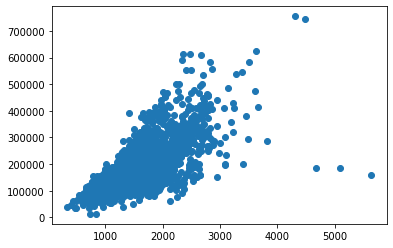

In [1328]:
plt.scatter(ames_data.Gr_Liv_Area, ames_data.Sale_Price)
plt.show()

In [1329]:
ames_data[ames_data.Gr_Liv_Area >  4500].index

Int64Index([1498, 2180, 2181], dtype='int64')

In [1330]:
ames_data = ames_data.iloc[~ames_data.index.isin(ames_data[ames_data.Gr_Liv_Area >  4500].index), :]

## <a id = '3'>3. EDA<a/>

### <a id='1.1'> 3.1 Categorical Variables Selection<a/>

In [1331]:
categorical_vars = df_info[df_info['Data Type'] == 'object']
categorical_vars['Number of Categories'] = [len(ames_data[col].value_counts()) for col in categorical_vars.column]

In [1332]:
categorical_vars

,column,Null Count,Data Type,Number of Categories
1,MS_SubClass,0,object,16
2,MS_Zoning,0,object,7
5,Street,0,object,2
6,Alley,0,object,3
7,Lot_Shape,0,object,4
8,Land_Contour,0,object,4
9,Utilities,0,object,3
10,Lot_Config,0,object,5
11,Land_Slope,0,object,3
12,Neighborhood,0,object,28


Lets visualize features that have less than 10 categories

In [1333]:
cols = categorical_vars

In [1334]:
import plotly.express as px
figures = []
for col in categorical_vars.column:
    fig = px.box(ames_data, x=col, y="Sale_Price", points="all", color = col)
    figures.append(fig)

By looking at the boxplots, below categorical variable seem to provide variation that matches with sales price. Five stars provide max variance.

- Sale_Type *****
- Sale_Condition ****
- Paved_Drive ****
- Garage_Finish ****
- Garage_Type ****
- Fireplace_Qu ****
- Kitchen_Qual *****
- Central_Air *****
- Heating_QC ****
- Electrical ***
- Bsmt_Exposure ****
- Bsmt_Qual *****
- Foundation ***
- Exter_Qual *****
- Overall_Qual *****
- Condition_1 ***
- Neighborhood ****
- MS_Zoning ****
- MS_SubClass ***

In [1335]:
# for fig in figures:
#     fig.show()

In [1336]:
# fig = px.box(ames_data, x="Sale_Type", y="Sale_Price")
# fig.show()

In [1337]:
# Selected Categorical Variables: 
selected_cat_col = ['Sale_Type', 'Fireplace_Qu', 'Kitchen_Qual', 'Central_Air', 'Heating_QC', 'Bsmt_Exposure', 
 'Bsmt_Qual', 'Exter_Qual', 'Overall_Qual', 'Neighborhood', 'MS_Zoning', 'Garage_Type', 'Sale_Condition', 
 'Paved_Drive', 'Garage_Finish', 'MS_SubClass', 'Electrical','Foundation', 'condition_1']

### <a id='1.1'> 3.1 Numerical Variables Selection<a/>

In [1338]:
num_vars = df_info[df_info['Data Type'] != 'object']
num_vars.column

0                    PID
3           Lot_Frontage
4               Lot_Area
19            Year_Built
20        Year_Remod_Add
26          Mas_Vnr_Area
34          BsmtFin_SF_1
36          BsmtFin_SF_2
37           Bsmt_Unf_SF
38         Total_Bsmt_SF
43          First_Flr_SF
44         Second_Flr_SF
45       Low_Qual_Fin_SF
46           Gr_Liv_Area
47        Bsmt_Full_Bath
48        Bsmt_Half_Bath
49             Full_Bath
50             Half_Bath
51         Bedroom_AbvGr
52         Kitchen_AbvGr
54         TotRms_AbvGrd
56            Fireplaces
59         Garage_Yr_Blt
61           Garage_Cars
62           Garage_Area
66          Wood_Deck_SF
67         Open_Porch_SF
68        Enclosed_Porch
69    Three_season_porch
70          Screen_Porch
71             Pool_Area
75              Misc_Val
76               Mo_Sold
77             Year_Sold
80             Longitude
81              Latitude
82            Sale_Price
Name: column, dtype: object

In [1339]:
# We can drop PID since this won't affect Sale_Price
num_vars= num_vars.iloc[1:, :]
num_vars

,column,Null Count,Data Type
3,Lot_Frontage,0,int64
4,Lot_Area,0,int64
19,Year_Built,0,int64
20,Year_Remod_Add,0,int64
26,Mas_Vnr_Area,0,int64
34,BsmtFin_SF_1,0,int64
36,BsmtFin_SF_2,0,int64
37,Bsmt_Unf_SF,0,int64
38,Total_Bsmt_SF,0,int64
43,First_Flr_SF,0,int64


- We can eleminate variables using co-relation plot
> $$Corr(x, y) = {\displaystyle \rho _{X,Y}=\operatorname {corr} (X,Y)={\operatorname {cov} (X,Y) \over \sigma _{X}\sigma _{Y}}={\operatorname {E} [(X-\mu _{X})(Y-\mu _{Y})] \over \sigma _{X}\sigma _{Y}}}$$

Alternatively,
$$ Corr(x,y) = {\displaystyle \rho _{X,Y}={\operatorname {E} (XY)-\operatorname {E} (X)\operatorname {E} (Y) \over {\sqrt {\operatorname {E} (X^{2})-\operatorname {E} (X)^{2}}}\cdot {\sqrt {\operatorname {E} (Y^{2})-\operatorname {E} (Y)^{2}}}}}$$


Sample correlation coefficient(r) $$ r = {\frac {\sum \limits _{i=1}^{n}(x_{i}-{\bar {x}})(y_{i}-{\bar {y}})}{\sqrt {\sum \limits _{i=1}^{n}(x_{i}-{\bar {x}})^{2}\sum \limits _{i=1}^{n}(y_{i}-{\bar {y}})^{2}}}} $$


In [1340]:
ames_num_cols_df = ames_data.loc[:, ames_data.columns.isin(num_vars.column.tolist())]

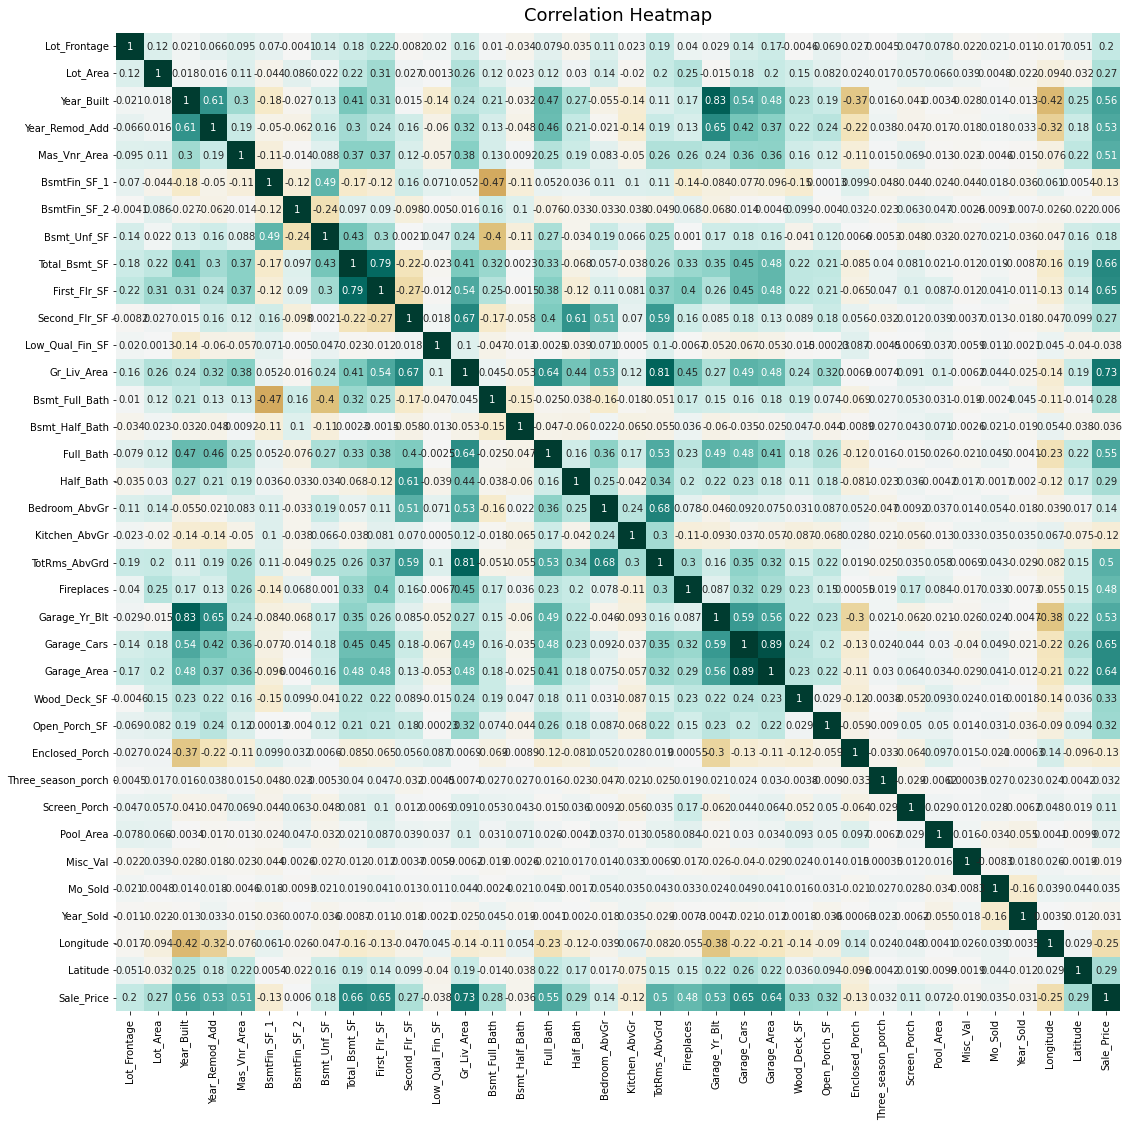

In [1341]:
plt.figure(figsize=(18, 18))
heatmap = sns.heatmap(ames_num_cols_df.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG', cbar=False)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=12);

- Below columns can be removed which have either high correlation with one of the predictor or little to no correlation with target variable
    - Garage_Yr_Blt (has high correlation with year built)
    - 'Lot_Fontage', 'BsmtFin_SF_1', 'BsmtFin_SF_2', 'Bsmt_Unit_SF', 'Second_Flr_SF', 'Bsmt_Half_Bath', 'Half_Bath', 'Bedroom_AbvGrd', 'Enclosed_Porch', 'Three_season_porch', 'Screen_Porch', 'Pool_Area', 'Misc_Val', 'Mo_Sold', 'Year_Sold'

In [1342]:
corr_df = ames_num_cols_df.corr()
corr_df_shortlisted = corr_df.loc[corr_df['Sale_Price'] > 0.3,:]
corr_df_shortlisted = corr_df_shortlisted.loc[:, corr_df_shortlisted.columns.isin(corr_df_shortlisted.index)]
corr_df_shortlisted = corr_df_shortlisted.loc[~corr_df_shortlisted.index.isin(['Garage_Yr_Blt']), ~corr_df_shortlisted.columns.isin(['Garage_Yr_Blt'])]
corr_df_shortlisted

,Year_Built,Year_Remod_Add,Mas_Vnr_Area,Total_Bsmt_SF,First_Flr_SF,Gr_Liv_Area,Full_Bath,TotRms_AbvGrd,Fireplaces,Garage_Cars,Garage_Area,Wood_Deck_SF,Open_Porch_SF,Sale_Price
Year_Built,1.000000,0.611544,0.304898,0.414839,0.312032,0.239554,0.468696,0.108051,0.168660,0.537419,0.479890,0.227457,0.194981,0.558918
Year_Remod_Add,0.611544,1.000000,0.188584,0.301081,0.241451,0.317193,0.456567,0.194641,0.131276,0.423686,0.374200,0.216370,0.239239,0.533411
Mas_Vnr_Area,0.304898,0.188584,1.000000,0.372250,0.369889,0.381326,0.251762,0.263727,0.263633,0.355387,0.361687,0.158023,0.117621,0.508375
Total_Bsmt_SF,0.414839,0.301081,0.372250,1.000000,0.785267,0.408140,0.329841,0.258950,0.325702,0.447951,0.477810,0.223708,0.214743,0.660810
First_Flr_SF,0.312032,0.241451,0.369889,0.785267,1.000000,0.535045,0.376081,0.372162,0.402221,0.446693,0.483615,0.218785,0.205792,0.645589
Gr_Liv_Area,0.239554,0.317193,0.381326,0.408140,0.535045,1.000000,0.638898,0.807220,0.451680,0.493425,0.475429,0.244085,0.316614,0.727122
Full_Bath,0.468696,0.456567,0.251762,0.329841,0.376081,0.638898,1.000000,0.528921,0.228717,0.476200,0.405618,0.178243,0.255261,0.546369
TotRms_AbvGrd,0.108051,0.194641,0.263727,0.258950,0.372162,0.807220,0.528921,1.000000,0.297282,0.353844,0.318679,0.147682,0.219032,0.500005
Fireplaces,0.168660,0.131276,0.263633,0.325702,0.402221,0.451680,0.228717,0.297282,1.000000,0.320991,0.288510,0.225306,0.151801,0.476386
Garage_Cars,0.537419,0.423686,0.355387,0.447951,0.446693,0.493425,0.476200,0.353844,0.320991,1.000000,0.892446,0.238712,0.200683,0.648141


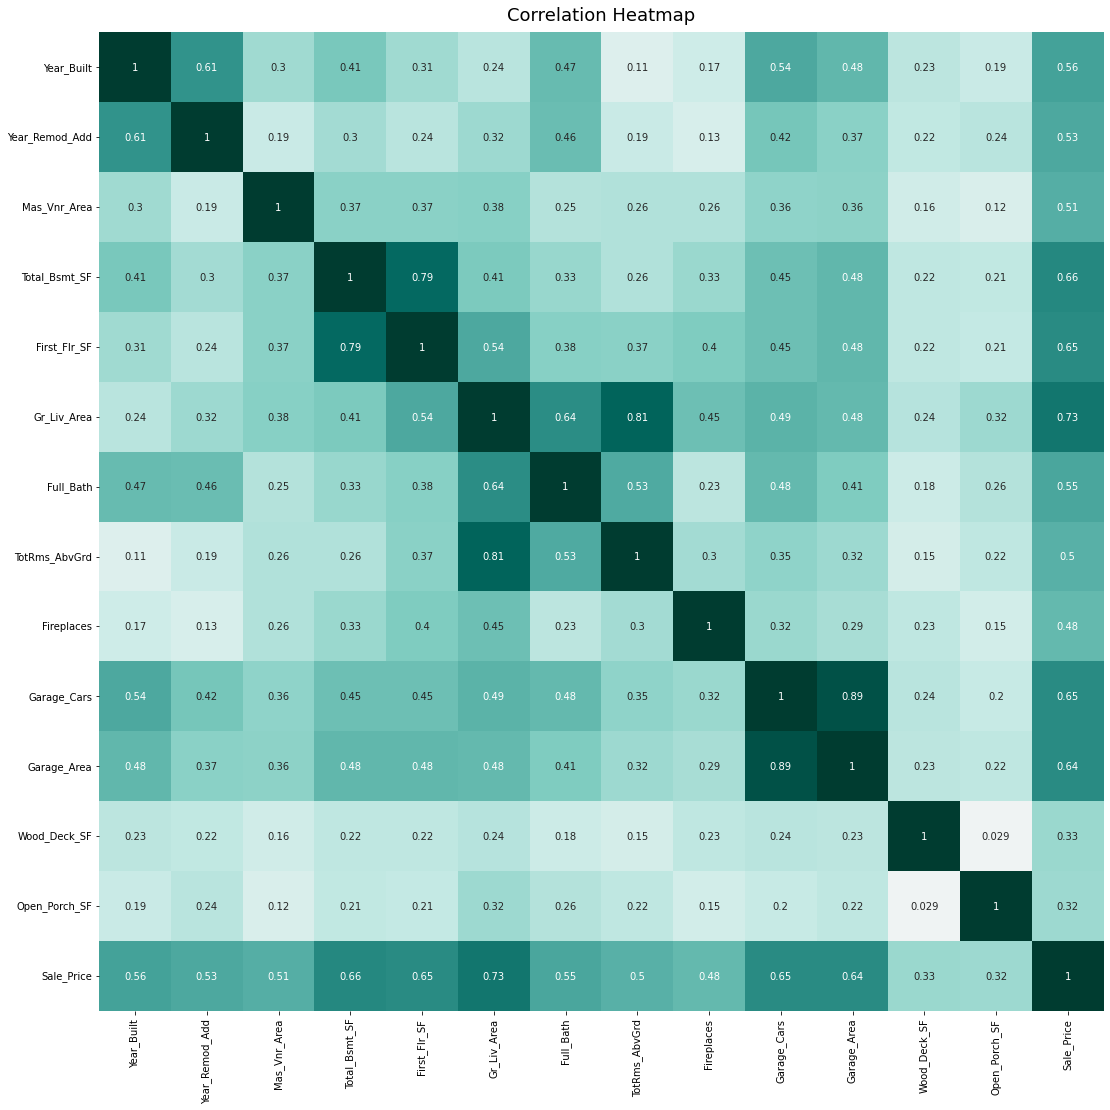

In [1343]:
plt.figure(figsize=(18, 18))
heatmap = sns.heatmap(corr_df_shortlisted, vmin=-1, vmax=1, annot=True, cmap='BrBG', cbar=False)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=12);

Further we can remove below variables that are highly correlated with each other.
1. Garage_Area (r = 0.9 with Garage_Cars)
2. TotRms_AbvGrd (r = 0.8 with Gr_Liv_Area)
3. First_Flr_SF (r = 0.8 with Total_Bsmt_SF)

In [1344]:
corr_df_shortlisted = corr_df_shortlisted.loc[~corr_df_shortlisted.index.isin(['Garage_Area', 'Garage_Area', 'First_Flr_SF']), ~corr_df_shortlisted.columns.isin(['Garage_Area', 'Garage_Area', 'First_Flr_SF'])]

In [1345]:
corr_df_shortlisted

,Year_Built,Year_Remod_Add,Mas_Vnr_Area,Total_Bsmt_SF,Gr_Liv_Area,Full_Bath,TotRms_AbvGrd,Fireplaces,Garage_Cars,Wood_Deck_SF,Open_Porch_SF,Sale_Price
Year_Built,1.000000,0.611544,0.304898,0.414839,0.239554,0.468696,0.108051,0.168660,0.537419,0.227457,0.194981,0.558918
Year_Remod_Add,0.611544,1.000000,0.188584,0.301081,0.317193,0.456567,0.194641,0.131276,0.423686,0.216370,0.239239,0.533411
Mas_Vnr_Area,0.304898,0.188584,1.000000,0.372250,0.381326,0.251762,0.263727,0.263633,0.355387,0.158023,0.117621,0.508375
Total_Bsmt_SF,0.414839,0.301081,0.372250,1.000000,0.408140,0.329841,0.258950,0.325702,0.447951,0.223708,0.214743,0.660810
Gr_Liv_Area,0.239554,0.317193,0.381326,0.408140,1.000000,0.638898,0.807220,0.451680,0.493425,0.244085,0.316614,0.727122
Full_Bath,0.468696,0.456567,0.251762,0.329841,0.638898,1.000000,0.528921,0.228717,0.476200,0.178243,0.255261,0.546369
TotRms_AbvGrd,0.108051,0.194641,0.263727,0.258950,0.807220,0.528921,1.000000,0.297282,0.353844,0.147682,0.219032,0.500005
Fireplaces,0.168660,0.131276,0.263633,0.325702,0.451680,0.228717,0.297282,1.000000,0.320991,0.225306,0.151801,0.476386
Garage_Cars,0.537419,0.423686,0.355387,0.447951,0.493425,0.476200,0.353844,0.320991,1.000000,0.238712,0.200683,0.648141
Wood_Deck_SF,0.227457,0.216370,0.158023,0.223708,0.244085,0.178243,0.147682,0.225306,0.238712,1.000000,0.028999,0.327985


Visualizing Lattitude and Longitude and sales price

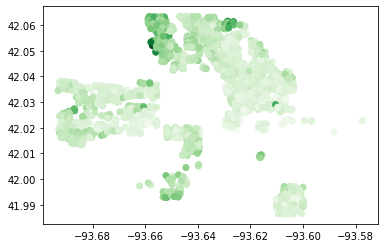

In [1346]:
plt.scatter(ames_data.Longitude, ames_data.Latitude, c=ames_data.Sale_Price, cmap='Greens')
plt.show()

- We can see that there are some spots where prices are high, for most part, price is constant.

## <a id="#">3. Modeling</a>

In [1347]:
selected_cat_col.extend(corr_df_shortlisted.columns)

In [1348]:
ames_final = ames_data.loc[:, ames_data.columns.isin(selected_cat_col)]
ames_final.head()

,MS_SubClass,MS_Zoning,Neighborhood,Overall_Qual,Year_Built,Year_Remod_Add,Mas_Vnr_Area,Exter_Qual,Foundation,Bsmt_Qual,...,Fireplace_Qu,Garage_Type,Garage_Finish,Garage_Cars,Paved_Drive,Wood_Deck_SF,Open_Porch_SF,Sale_Type,Sale_Condition,Sale_Price
0,One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,North_Ames,Above_Average,1960,1960,112,Typical,CBlock,Typical,...,Good,Attchd,Fin,2,Partial_Pavement,210,62,WD,Normal,215000
1,One_Story_1946_and_Newer_All_Styles,Residential_High_Density,North_Ames,Average,1961,1961,0,Typical,CBlock,Typical,...,No_Fireplace,Attchd,Unf,1,Paved,140,0,WD,Normal,105000
2,One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,North_Ames,Above_Average,1958,1958,108,Typical,CBlock,Typical,...,No_Fireplace,Attchd,Unf,1,Paved,393,36,WD,Normal,172000
3,One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,North_Ames,Good,1968,1968,0,Good,CBlock,Typical,...,Typical,Attchd,Fin,2,Paved,0,0,WD,Normal,244000
4,Two_Story_1946_and_Newer,Residential_Low_Density,Gilbert,Average,1997,1998,0,Typical,PConc,Good,...,Typical,Attchd,Fin,2,Paved,212,34,WD,Normal,189900


### <a id='3.3'> 3.2 XgBoost<a/>

In [1349]:
from sklearn import preprocessing
lbl = preprocessing.LabelEncoder()
X = ames_final.loc[:, ~ames_final.columns.str.contains('Sale_Price')]
y = ames_final['Sale_Price']

In [1350]:
for col in ames_final.columns:
    if ames_final[col].dtype == 'object':
        X[col] = lbl.fit_transform(X[col].astype(str))

In [1351]:
ames_final.iloc[test_ids[0],:]

,MS_SubClass,MS_Zoning,Neighborhood,Overall_Qual,Year_Built,Year_Remod_Add,Mas_Vnr_Area,Exter_Qual,Foundation,Bsmt_Qual,...,Fireplace_Qu,Garage_Type,Garage_Finish,Garage_Cars,Paved_Drive,Wood_Deck_SF,Open_Porch_SF,Sale_Type,Sale_Condition,Sale_Price
902,One_and_Half_Story_Finished_All_Ages,Residential_Low_Density,Edwards,Above_Average,1920,2000,0,Typical,BrkTil,Typical,...,No_Fireplace,Detchd,Unf,2,Paved,0,46,ConLI,Normal,110000
755,One_Story_1945_and_Older,Residential_Medium_Density,Iowa_DOT_and_Rail_Road,Below_Average,1925,1950,0,Typical,CBlock,Typical,...,No_Fireplace,Detchd,Unf,2,Paved,0,23,WD,Normal,103000
1619,Split_or_Multilevel,Residential_Low_Density,Gilbert,Above_Average,1997,1997,0,Typical,PConc,Good,...,Typical,BuiltIn,Fin,2,Paved,0,0,WD,Normal,161500
166,One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,North_Ames,Average,1960,1960,0,Typical,CBlock,Typical,...,No_Fireplace,Detchd,RFn,2,Paved,0,0,WD,Normal,148000
1371,One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,Sawyer,Average,1947,1993,0,Good,CBlock,Typical,...,No_Fireplace,Detchd,Unf,1,Paved,0,60,WD,Abnorml,124000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1655,Two_Story_1946_and_Newer,Residential_Low_Density,Northwest_Ames,Average,1969,1969,263,Typical,CBlock,Typical,...,No_Fireplace,Attchd,Fin,2,Paved,208,0,WD,Normal,152000
1496,One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,Edwards,Below_Average,2005,2005,0,Typical,PConc,Good,...,No_Fireplace,Attchd,Fin,2,Paved,252,64,WD,Normal,176000
1779,One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,Somerset,Very_Good,2006,2006,248,Good,PConc,Good,...,Good,Attchd,Fin,2,Paved,168,46,WD,Family,215000
96,Two_Story_PUD_1946_and_Newer,Floating_Village_Residential,Somerset,Good,2004,2005,0,Good,PConc,Good,...,No_Fireplace,Detchd,RFn,2,Paved,0,172,WD,Normal,151000


In [1352]:
X_train = X.iloc[~X.index.isin(test_ids[0]),:]
X_test = X.iloc[X.index.isin(test_ids[0]),:]
y_train = ames_final.iloc[~ames_final.index.isin(test_ids[0]),:]['Sale_Price']
y_test = ames_final.iloc[ames_final.index.isin(test_ids[0]),:]['Sale_Price']

In [1353]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [1354]:
# set parameters for model
param = {'max_depth': 50, 'eta': 0.1, 'objective': 'reg:squarederror'}
param['nthread'] = 4
param['eval_metric'] = 'rmsle'

In [1355]:
# Specify validations set to watch performance
evallist = [(dtest, 'eval'), (dtrain, 'train')]

In [1356]:
num_round = 20
bst = xgb.train(param, dtrain, num_round, evallist)

[0]	eval-rmsle:2.32668	train-rmsle:2.31107
[1]	eval-rmsle:1.67384	train-rmsle:1.66599
[2]	eval-rmsle:1.31982	train-rmsle:1.31162
[3]	eval-rmsle:1.08146	train-rmsle:1.07432
[4]	eval-rmsle:0.90891	train-rmsle:0.90046
[5]	eval-rmsle:0.77543	train-rmsle:0.76698
[6]	eval-rmsle:0.67070	train-rmsle:0.66049
[7]	eval-rmsle:0.58583	train-rmsle:0.57370
[8]	eval-rmsle:0.51531	train-rmsle:0.50170
[9]	eval-rmsle:0.45645	train-rmsle:0.44133
[10]	eval-rmsle:0.40706	train-rmsle:0.39013
[11]	eval-rmsle:0.36591	train-rmsle:0.34635
[12]	eval-rmsle:0.33196	train-rmsle:0.30854
[13]	eval-rmsle:0.30310	train-rmsle:0.27587
[14]	eval-rmsle:0.27715	train-rmsle:0.24724
[15]	eval-rmsle:0.25612	train-rmsle:0.22226
[16]	eval-rmsle:0.23808	train-rmsle:0.20047
[17]	eval-rmsle:0.22323	train-rmsle:0.18115
[18]	eval-rmsle:0.21025	train-rmsle:0.16404
[19]	eval-rmsle:0.19952	train-rmsle:0.14891


In [1357]:
ypred = bst.predict(dtest)

In [1358]:
def calc_rmsle(ypred, ytest):
#     return np.sqrt(np.mean((ypred - ytest)**2))
    return np.sqrt(np.mean((np.log(ypred) - np.log(ytest))**2))
calc_rmsle(ypred, y_test)

0.1995235036036854

### Hyperparameters tuning

In [1359]:
# Create a list of hyperparameters
# ref: https://stackoverflow.com/questions/12130883/r-expand-grid-function-in-python
from itertools import product

def expand_grid(dictionary):
    return pd.DataFrame([row for row in product(*dictionary.values())], 
                       columns=dictionary.keys())

params = {
        'max_depth': [500],
        'eta': [0.1, 0.15, 0.2, 0.25],
        'min_child_weight': [5, 7],
        'gamma': [200, 2000, 10000],
        'subsample': [0.8],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'objective': ['reg:squarederror'],
        'reg_alpha':[50, 100]
        }
params_df = expand_grid(params)

In [1360]:
params_df.head()

,max_depth,eta,min_child_weight,gamma,subsample,colsample_bytree,objective,reg_alpha
0,500,0.1,5,200,0.8,0.6,reg:squarederror,50
1,500,0.1,5,200,0.8,0.6,reg:squarederror,100
2,500,0.1,5,200,0.8,0.8,reg:squarederror,50
3,500,0.1,5,200,0.8,0.8,reg:squarederror,100
4,500,0.1,5,200,0.8,1.0,reg:squarederror,50


In [1361]:
# ames_final.drop(['Central_Air', 'Paved_Drive', 'Electrical', 'Full_Bath', 'Exter_Qual', 'Foundation', 'Sale_Type'], axis=1, inplace=True)

In [1362]:
from sklearn import preprocessing
lbl = preprocessing.LabelEncoder()
X = ames_final.loc[:, ~ames_final.columns.str.contains('Sale_Price')]
y = ames_final['Sale_Price']

In [1363]:
for col in ames_final.columns:
    if ames_final[col].dtype == 'object':
        X[col] = lbl.fit_transform(X[col].astype(str))

In [1372]:
X_train = X.iloc[~X.index.isin(test_ids[4]),:]
X_test = X.iloc[X.index.isin(test_ids[4]),:]
y_train = ames_final.iloc[~ames_final.index.isin(test_ids[4]),:]['Sale_Price']
y_test = ames_final.iloc[ames_final.index.isin(test_ids[4]),:]['Sale_Price']

In [1373]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

<hr>

In [1374]:
# from sklearn import preprocessing
# lbl = preprocessing.LabelEncoder()
# X = ames_data.loc[:, ~ames_data.columns.str.contains('Sale_Price')]
# y = ames_data['Sale_Price']

In [1375]:
# for col in ames_data.columns:
#     if ames_data[col].dtype == 'object':
#         X[col] = lbl.fit_transform(X[col].astype(str))

In [1376]:
# X_train = X.iloc[~X.index.isin(test_ids[0]),:]
# X_test = X.iloc[X.index.isin(test_ids[0]),:]
# y_train = ames_data.iloc[~ames_data.index.isin(test_ids[0]),:]['Sale_Price']
# y_test = ames_data.iloc[ames_data.index.isin(test_ids[0]),:]['Sale_Price']

In [1377]:
# dtrain = xgb.DMatrix(X_train, label=y_train)
# dtest = xgb.DMatrix(X_test, label=y_test)

<hr>

In [1378]:
rmsles = {}
for num in [60]:
    for idx in params_df.index:
        param = params_df.iloc[idx,:].to_dict()
        param['nthread'] = 4
        param['eval_metric'] = 'rmsle'
        evallist = [(dtest, 'eval'), (dtrain, 'train')]
        num_round = num
        bst = xgb.train(param, dtrain, num_round, evallist, verbose_eval=False)
        ypred = bst.predict(dtest)
        rmsle = calc_rmsle(ypred, y_test)
        rmsles.update({rmsle:param})

In [1379]:
print(min(rmsles.keys()))
rmsles[min(rmsles.keys())]

0.1396882759151403


{'max_depth': 500,
 'eta': 0.1,
 'min_child_weight': 5,
 'gamma': 2000,
 'subsample': 0.8,
 'colsample_bytree': 0.6,
 'objective': 'reg:squarederror',
 'reg_alpha': 50,
 'nthread': 4,
 'eval_metric': 'rmsle'}

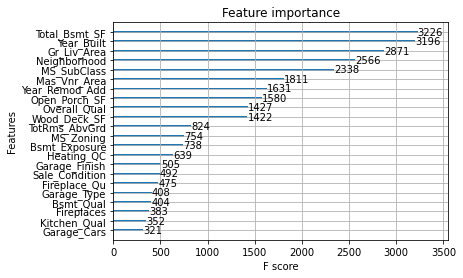

In [1314]:
xgb.plot_importance(bst)
plt.show()

In [1178]:
print(min(rmsles.keys()))
rmsles[min(rmsles.keys())]

0.12306065865657737


{'max_depth': 500,
 'eta': 0.1,
 'gamma': 2000,
 'subsample': 0.8,
 'colsample_bytree': 0.6,
 'objective': 'reg:squarederror',
 'reg_alpha': 50,
 'nthread': 4,
 'eval_metric': 'rmsle'}

In [1315]:
param = rmsles[min(rmsles.keys())]
param['nthread'] = 4
param['eval_metric'] = 'rmsle'

num_round = num

for idx in range(10):
    X_train = X.iloc[~X.index.isin(test_ids[idx]),:]
    X_test = X.iloc[X.index.isin(test_ids[idx]),:]
    
    y_train = ames_final.iloc[~ames_final.index.isin(test_ids[idx]),:]['Sale_Price']
    y_test = ames_final.iloc[ames_final.index.isin(test_ids[idx]),:]['Sale_Price']
    
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test)

    evallist = [(dtest, 'eval'), (dtrain, 'train')]
    bst = xgb.train(param, dtrain, num_round, evallist, verbose_eval=False)
    dtest = xgb.DMatrix(X_test, label=y_test)
    ypred = bst.predict(dtest)
    rmsle = calc_rmsle(ypred, y_test)
    print(rmsle)

0.1445298328775064
0.12883336751597016
0.13615676348567624
0.1382681366048608
0.1444877528102359
0.14628480801118324
0.1258570942694726
0.1403291148437623
0.13980853571926696
0.1497588845936559


In [1170]:
param = rmsles[min(rmsles.keys())]
param['nthread'] = 4
param['eval_metric'] = 'rmsle'
evallist = [(dtest, 'eval'), (dtrain, 'train')]
num_round = num
        
bst = xgb.train(param, dtrain, num_round, evallist, verbose_eval=False)

for idx in range(10):
    X_train = X.iloc[~X.index.isin(test_ids[idx]),:]
    X_test = X.iloc[X.index.isin(test_ids[idx]),:]
    
    y_train = ames_final.iloc[~ames_final.index.isin(test_ids[idx]),:]['Sale_Price']
    y_test = ames_final.iloc[ames_final.index.isin(test_ids[idx]),:]['Sale_Price']
    
    dtest = xgb.DMatrix(X_test, label=y_test)
    ypred = bst.predict(dtest)
    rmsle = calc_rmsle(ypred, y_test)
    print(rmsle)
print(param)

0.13414919463817943
0.06699064093408942
0.07647631995021398
0.07774106173146944
0.0824890691805489
0.13409137789953104
0.06699075736099468
0.07609012130309704
0.07774113646527088
0.08248894204131507
{'max_depth': 500, 'eta': 0.15, 'gamma': 200, 'subsample': 0.8, 'colsample_bytree': 0.6, 'objective': 'reg:squarederror', 'reg_alpha': 100, 'nthread': 4, 'eval_metric': 'rmsle'}


In [1164]:
from sklearn.model_selection import KFold, cross_val_score, train_test_split

In [1165]:
#Validation function
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(X.values)
    rmse= np.sqrt(-cross_val_score(model, X.values, y, scoring="neg_mean_squared_log_error", cv = kf))
    return(rmse)

In [1166]:
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=100, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, random_state =7, nthread = 4)

In [1167]:
score = rmsle_cv(model_xgb)

In [1168]:
print("Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Xgboost score: 0.1364 (0.0080)



## <a id = 'data_dict'>Data Dictionary<a/>
    
- Below is the data dictionary
    - PID: the Parcel identification number
    - SalePrice: the property's sale price in dollars. This is the target variable that you're trying to predict.
    - MSSubClass: The building class
    - MSZoning: The general zoning classification
    - LotFrontage: Linear feet of street connected to property
    -  LotArea: Lot size in square feet
    - Street: Type of road access
    -   Alley: Type of alley access
    -   LotShape: General shape of property
    - LandContour: Flatness of the property
    - Utilities: Type of utilities available
    -   LotConfig: Lot configuration
    - LandSlope: Slope of property
    - Neighborhood: Physical locations within Ames city limits
    -   Condition1: Proximity to main road or railroad
    -   Condition2: Proximity to main road or railroad (if a second is present)
    -  BldgType: Type of dwelling
    -   HouseStyle: Style of dwelling
    -  OverallCond: Overall condition rating
    -   YearBuilt: Original construction date
    -   YearRemodAdd: Remodel date
    -   RoofStyle: Type of roof
    -   RoofMatl: Roof material
    -   Exterior1st: Exterior covering on house
    -   MasVnrArea: Masonry veneer area in square feet
    -     ExterQual: Exterior material quality
    -    ExterCond: Present condition of the material on the exterior
    - BsmtQual: Height of the basement
    -    BsmtCond: General condition of the basement
    -   BsmtExposure: Walkout or garden level basement walls
    -    BsmtFinType1: Quality of basement finished area
    -    BsmtFinSF1: Type 1 finished square feet
    -    BsmtFinType2: Quality of second finished area (if present)
    -    BsmtFinSF2: Type 2 finished square feet
    -    BsmtUnfSF: Unfinished square feet of basement area
    -    TotalBsmtSF: Total square feet of basement area
    -   Heating: Type of heating
    -   HeatingQC: Heating quality and condition
    -   CentralAir: Central air conditioning
    -   Electrical: Electrical system
    -    1stFlrSF: First Floor square feet
    -    2ndFlrSF: Second floor square feet
    -    LowQualFinSF: Low quality finished square feet (all floors)
    -    GrLivArea: Above grade (ground) living area square feet
    -    BsmtFullBath: Basement full bathrooms
    -    BsmtHalfBath: Basement half bathrooms
    -    FullBath: Full bathrooms above grade
    -    HalfBath: Half baths above grade
    -    Bedroom: Number of bedrooms above basement level
    -    Kitchen: Number of kitchens
    -    KitchenQual: Kitchen quality
    -   TotRmsAbvGrd: Total rooms above grade (does not include bathrooms)
    -    Functional: Home functionality rating
    - FireplaceQu: Fireplace quality
    -  GarageType: Garage location
    - GarageYrBlt: Year garage was built
    -  GarageFinish: Interior finish of the garage
    -   GarageCars: Size of garage in car capacity
    -    GarageArea: Size of garage in square feet
    -   GarageQual: Garage quality
    -   GarageCond: Garage condition
    -   PavedDrive: Paved driveway
    -   WoodDeckSF: Wood deck area in square feet
    -   OpenPorchSF: Open porch area in square feet
    - EnclosedPorch: Enclosed porch area in square feet
    -   3SsnPorch: Three season porch area in square feet
    -   ScreenPorch: Screen porch area in square feet
    -   PoolArea: Pool area in square feet
    -   PoolQC: Pool quality
    -   Fence: Fence quality
    -   MiscFeature: Miscellaneous feature not covered in other categories
    -   MiscVal: $Value of miscellaneous feature
    -   MoSold: Month Sold
    -   YrSold: Year Sold
    -   SaleType: Type of sale
    -   SaleCondition: Condition of sale